In [1]:
#imports
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('..')
import scipy as sp

from extremevalue.gpd import GEVMLE_ts

In [2]:
import pymc as pm
import pymc_experimental.distributions as pmx
import arviz as az

In [3]:
def load_daily_max_prcp(filename):
    df = pd.read_csv(filename,parse_dates=['valid'],usecols=['valid','station','precip_in'])
    df = df.rename(columns={'valid':'datetime'})
    df['date'] = df['datetime'].dt.date
    df['date'] = df['date'].astype('datetime64[ns]')
    df['time'] = df['datetime'].dt.time
    df = df.groupby(['date','station'])['precip_in'].max()
    return df.unstack('station')

In [57]:
# df_NY_airports_hourly_max = load_daily_max_prcp('../NY_airports_hourly_prcp.csv')
# df_NJ_airports_hourly_max = load_daily_max_prcp('../NJ_airports_hourly_prcp.csv')
# df_CT_airports_hourly_max = load_daily_max_prcp('../CT_hourly.csv')
# df_PA_airports_hourly_max = load_daily_max_prcp('../PA_hourly.csv')
# df_RI_airports_hourly_max = load_daily_max_prcp('../RI_hourly.csv')
# df_MA_airports_hourly_max = load_daily_max_prcp('../MA_hourly.csv')
df_DE_airports_hourly_max = load_daily_max_prcp('../DE_hourly.csv')

In [59]:
df_DE_airports_hourly_max

station,DOV,ILG
date,,
1950-12-31,NaN,0.0900
1957-09-07,NaN,0.7300
1957-09-09,NaN,0.0100
1957-09-10,NaN,1.3400
1957-09-11,NaN,0.1800
...,...,...
2023-08-12,0.00,0.0001
2023-08-13,0.00,0.0001
2023-08-14,0.06,0.0900


In [58]:
# df_CT_airports_hourly_max.loc['1970-01-01':].groupby(lambda x:x.year).count() #['BDL']
# df_PA_airports_hourly_max.loc['1970-01-01':].groupby(lambda x:x.year).count() #['ABE','PHL']
# df_NJ_airports_hourly_max.loc['1970-01-01':].groupby(lambda x:x.year).count() #['ACY','EWR']
# df_RI_airports_hourly_max.loc['1970-01-01':].groupby(lambda x:x.year).count() #['PVD']
# df_NY_airports_hourly_max.loc['1970-01-01':].groupby(lambda x:x.year).count() #['ALB','BGM', 'JFK', 'LGA']
# df_MA_airports_hourly_max.loc['1970-01-01':].groupby(lambda x:x.year).count() #['BOS']
# df_DE_airports_hourly_max.loc['1970-01-01':].groupby(lambda x:x.year).count() #['ILG']

station,DOV,ILG
date,,
1970,0,87
1971,0,92
1972,0,105
1973,0,115
1974,0,118
1975,0,133
1976,0,112
1977,0,126
1978,0,119


In [5]:
stations = pd.concat([
    pd.read_csv('../ny_stations.csv'),
    pd.read_csv('../nj_stations.csv')
])
stations = stations[['stid','station_name','lat','lon','elev']].set_index(['stid'])


In [25]:
stations.loc[['ALB','BGM','BUF','JFK','LGA','ROC', 'ACY']]

,station_name,lat,lon,elev
stid,,,,
ALB,ALBANY COUNTY ARPT,42.75757,-73.80361,89.0
BGM,BINGHAMTON/BROOME,42.20856,-75.97972,497.0
BUF,BUFFALO INTL ARPT,42.94080,-78.73580,215.0
JFK,NEW YORK/JF KENNEDY,40.63861,-73.76222,7.0
LGA,New York/LaGuardia,40.77945,-73.88028,9.0
ROC,ROCHESTER/MONROE CO,43.11670,-77.67670,169.0
ACY,ATLANTIC CITY INTL,39.45758,-74.57717,20.0


In [6]:
# df_NY_counts = df_NY_airports_hourly_max.groupby(lambda x:x.year).count()
df_NY_airports_hourly_max = df_NY_airports_hourly_max.loc['1970-01-01':'2022-12-31',['ALB','BGM','BUF','JFK','LGA','ROC']]
df_NJ_airports_hourly_max = df_NJ_airports_hourly_max.loc['1970-01-01':'2022-12-31',['ACY','EWR']]


In [7]:
df_NY_region_hourly_max = df_NY_airports_hourly_max.join(df_NJ_airports_hourly_max, how='outer')
df_NY_region_hourly_max = df_NY_region_hourly_max[sorted(df_NY_region_hourly_max.columns)]
df_NY_region_annual_max = df_NY_region_hourly_max.groupby(lambda x:x.year).max()

In [8]:
params = {}

for station in df_NY_region_hourly_max:

    GEV_hourly = GEVMLE_ts()
    GEV_hourly.fit(df_NY_region_hourly_max[station].fillna(0.0))
    station_params = GEV_hourly.get_params()
    station_params['10y'] = GEV_hourly.return_level(10)
    station_params['100y'] = GEV_hourly.return_level(100)
    station_params['10yse'] = GEV_hourly.return_level_se(10).item()
    station_params['100yse'] = GEV_hourly.return_level_se(100).item()
    params[station] = station_params

In [9]:
pd.DataFrame(params).T

,mu,sigma,xi,10y,100y,10yse,100yse
ACY,0.960162,0.392489,0.163698,2.028050,3.653751,0.200082,0.833115
ALB,0.846779,0.213258,0.167573,1.429709,2.325102,0.108171,0.428934
BGM,0.744401,0.246030,0.262252,1.498935,2.940999,0.155321,0.746398
BUF,0.791386,0.247622,0.300614,1.587897,3.251284,0.171864,0.913788
EWR,1.010923,0.313233,0.165943,1.865461,3.173123,0.161646,0.696984
JFK,0.984831,0.323643,0.141936,1.842901,3.085250,0.155777,0.609815
LGA,0.999008,0.340878,-0.017883,1.750878,2.504331,0.112338,0.321120
ROC,0.743930,0.254333,0.118664,1.399974,2.300215,0.116342,0.434068


In [10]:
ts_hourly_max = df_NY_region_hourly_max['JFK']
ts_annual_max = df_NY_region_annual_max['JFK']

GEV_hourly = GEVMLE_ts()
GEV_hourly.fit(ts_hourly_max)
GEV_hourly.get_params()

{'mu': 0.984831125432392,
 'sigma': 0.3236428951095842,
 'xi': 0.14193555821043535}

In [11]:
GEV_hourly.return_level(10)

1.8429005639378828

In [12]:
stations_X = stations.loc[df_NY_region_hourly_max.columns][['lat','lon']]
stations_X

,lat,lon
station,,
ACY,39.45758,-74.57717
ALB,42.75757,-73.80361
BGM,42.20856,-75.97972
BUF,42.94080,-78.73580
EWR,40.68272,-74.16932
JFK,40.63861,-73.76222
LGA,40.77945,-73.88028
ROC,43.11670,-77.67670


In [13]:
data =ts_annual_max.values

# return_periods = GEV_hourly._return_periods(n=50)
return_periods = np.logspace(0.01,2, num=100)
p = 1/return_periods

with pm.Model() as model:
    # Priors
    μ = pm.Normal("μ", mu=1.0, sigma=0.5)
    σ = pm.HalfNormal("σ", sigma=0.5)
    # ξ = pm.TruncatedNormal("ξ", mu=0, sigma=0.2, lower=-0.5, upper=0.5)
    ξ = pm.math.tanh(pm.Normal("ξ", mu=0, sigma=0.15))


    # Estimation
    gev = pmx.GenExtreme("gev", mu=μ, sigma=σ, xi=ξ, observed=data)
    # Return level
    z_p = pm.Deterministic("z_p", μ - σ / ξ * (1 - (-np.log(1 - p)) ** (-ξ)))

Sampling: [gev, μ, ξ, σ]


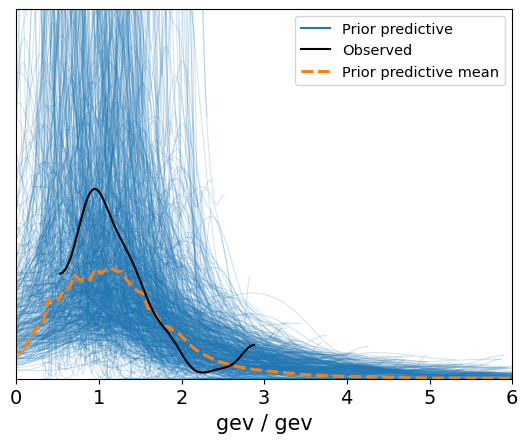

In [14]:
idata = pm.sample_prior_predictive(samples=1000, model=model)
az.plot_ppc(idata, group="prior")
ax = plt.gca()
ax.set_xlim([0, 6])
ax.set_ylim([0, 2]);

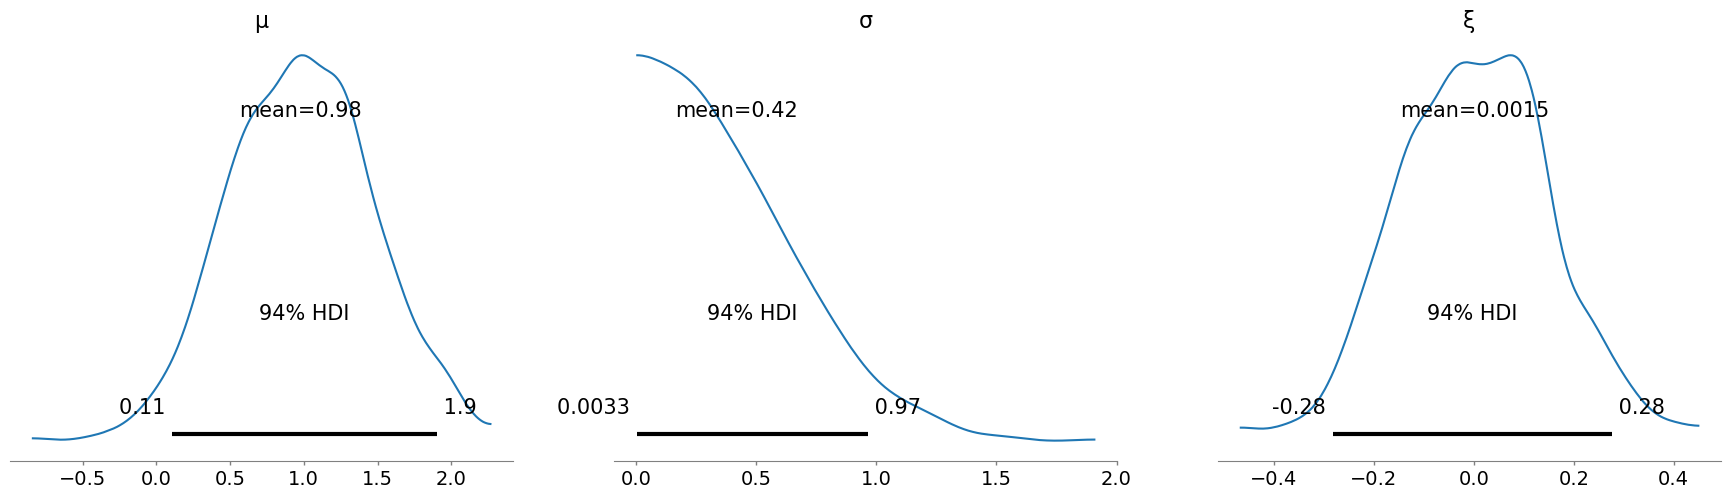

In [15]:
az.plot_posterior(
    idata, group="prior", var_names=["μ", "σ", "ξ"]
);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ, ξ]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 27 seconds.


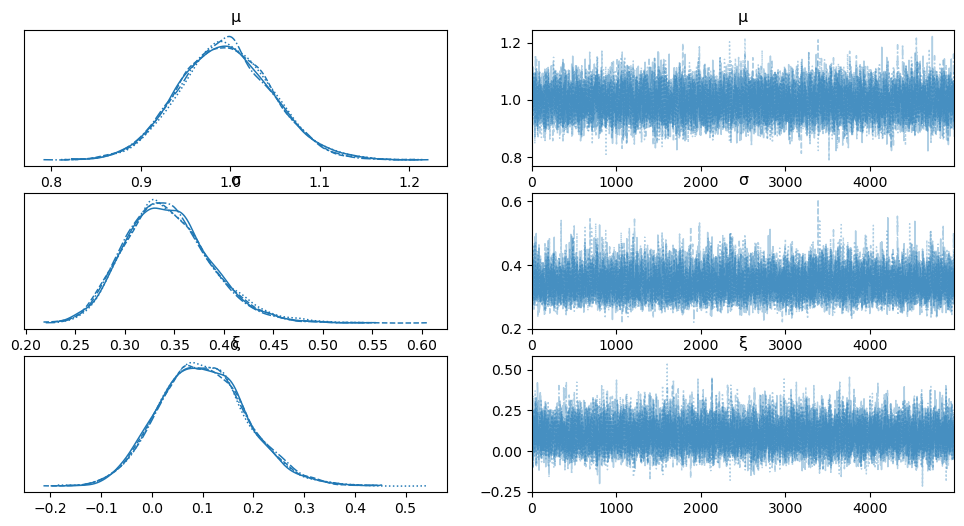

In [16]:
with model:
    trace = pm.sample(
        5000,
        # cores=4,
        # chains=4,
        # tune=2000,
        # initvals={"μ": -0.5, "σ": 1.0, "ξ": -0.1},
        target_accept=0.98,
    )
# add trace to existing idata object
idata.extend(trace)
az.plot_trace(idata, var_names=["μ", "σ", "ξ"]);

In [17]:
z_p_summary = az.summary(idata,var_names=['z_p'],hdi_prob= 0.95)
z_p_summary.index=return_periods

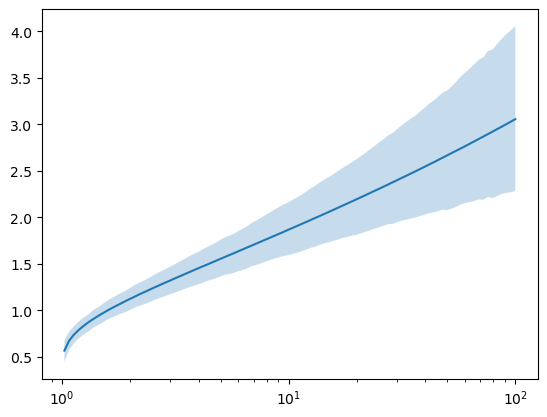

In [18]:
z_p_summary['mean'].plot()
plt.fill_between(z_p_summary.index,z_p_summary['hdi_2.5%'].values,z_p_summary['hdi_97.5%'].values,alpha=0.25)
plt.xscale("log")

In [19]:
z_p_summary


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
1.023293,0.565,0.060,0.444,0.674,0.001,0.000,15777.0,10997.0,1.0
1.071769,0.669,0.051,0.570,0.766,0.000,0.000,15923.0,11446.0,1.0
1.122541,0.732,0.047,0.637,0.823,0.000,0.000,14609.0,11794.0,1.0
1.175718,0.781,0.046,0.690,0.872,0.000,0.000,13192.0,11702.0,1.0
1.231414,0.822,0.046,0.731,0.913,0.000,0.000,11802.0,11476.0,1.0
...,...,...,...,...,...,...,...,...,...
83.099031,2.946,0.458,2.226,3.860,0.005,0.003,12210.0,9871.0,1.0
87.035608,2.972,0.468,2.249,3.917,0.005,0.003,12236.0,9809.0,1.0
91.158670,2.999,0.479,2.262,3.966,0.005,0.003,12260.0,9710.0,1.0
95.477050,3.026,0.490,2.267,4.007,0.005,0.004,12283.0,9776.0,1.0


In [20]:
GEV_hourly.return_level(100), GEV_hourly.return_level_se(100)

(3.085250101547203, array(0.60981525))

In [21]:
az.summary(idata,var_names=["μ", "σ", "ξ"],hdi_prob= 0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ,0.995,0.052,0.899,1.102,0.001,0.000,8458.0,10335.0,1.0
σ,0.344,0.043,0.264,0.429,0.000,0.000,8514.0,10715.0,1.0
ξ,0.101,0.086,-0.068,0.266,0.001,0.001,10343.0,10915.0,1.0


In [22]:
GEV_hourly.get_params()

{'mu': 0.984831125432392,
 'sigma': 0.3236428951095842,
 'xi': 0.14193555821043535}